# Ray Tracing in One Weekend _in Python_
We will start by following Peter Shirley's excellent C++
[_"Ray Tracing in One Weekend"_](https://raytracing.github.io/books/RayTracingInOneWeekend.html)
book series. Our goal is to write a ray tracer using only the Python standard library.
## 1. Writing image files.


We write image files in the ppm P3 text based image format.
* The first 3 lines contain the format, integer dimensions, and maximum color value.
        P3
        width height
        255
* Each pixel must be separated by white space. We will also use a newline for
    readability.
* Each pixel will is composed of its red, green, and blue components, in that order.
* We write pixels sequentially by row ie. left to right, top to bottom.
        P3
        width height
        255
        r g b
        r g b
         ...
        r g b

In [1]:
image_width = 256
image_height = 256

with open("images/image.ppm", "w") as image_file:
    image_file.write(f"P3\n{image_width} {image_height}\n255\n")
    for j in range(image_height - 1, 0, -1):
        for i in range(image_width):
            r = i / (image_width - 1)
            g = j / (image_height - 1)
            b = 0.25

            ir = int(255.999 * r)
            ig = int(255.999 * g)
            ib = int(255.999 * b)

            image_file.write(f"{ir} {ig} {ib}\n")

Our PPM file can now be viewed in many popular image applications, like GIMP. For the sake
of completion we read our image back in and necessarily leverage some libraries to
display it in this notebook.

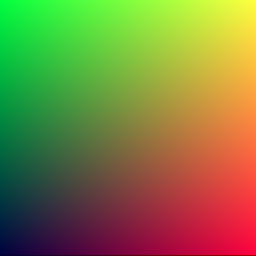

In [2]:
import numpy as np
from IPython.display import display
from PIL import Image

def ppm_to_image(filename):
    with open(filename, "r") as ppmfile:
        ppm = ppmfile.readlines()

    width, height = [int(x) for x in ppm[1].split(" ")]
    image = np.zeros((height, width, 3))
    # we read in row major
    pixel_colors = ppm[3:]

    index = 0
    for i in range(height-1):
        for j in range(width):
            pixel_color = [int(c) for c in pixel_colors[index].split(" ")]
            image[i, j] = np.array(pixel_color)
            index += 1

    return Image.fromarray(image.astype("uint8"))

image = ppm_to_image("images/image.ppm")
display(image)

###### _Figure 1. We read back in and display our image to ensure our output is as intended._

In [3]:
import math


class Vec3(object):
    def __init__(self, x, y, z):
        self.x, self.y, self.z = x, y, z
    
    def __iter__(self):
        yield from (self.x, self.y, self.z)
    
    def __neg__(self):
        return Vec3(*[-c for c in self])
    
    def __add__(self, rhs):
        if isinstance(rhs, Vec3):
            return Vec3(*[l + r for l, r in zip(self, rhs)])
        return Vec3(*[c + rhs for c in self])
    
    __radd__ = __add__
    
    def __sub__(self, rhs):
        return self + -rhs

    def __mul__(self, rhs):
        if isinstance(rhs, Vec3):
            return Vec3(*[l * r for l, r in zip(self, rhs)])
        return Vec3(*[c * rhs for c in self])
    
    __rmul__ = __mul__
    
    def __truediv__(self, rhs):
        return Vec3(*[c / rhs for c in self])

    def __str__(self):
        return str(self)

    def length(self):
        return math.sqrt(self.length_squared())
    
    def length_squared(self):
        return sum([c**2 for c in self])


Point3 = Vec3  # 3d point
Color = Vec3  # RGB color

In [4]:
def dot(lhs, rhs):
    assert isinstance(lhs, Vec3) and isinstance(rhs, Vec3), \
        "Expected two instances of Vec3 as input."
    return sum(l * r for l, r in zip(lhs, rhs))

def cross(lhs, rhs):
    assert isinstance(lhs, Vec3) and isinstance(rhs, Vec3), \
        "Expected two instances of Vec3 as input."
    return Vec3(lhs.y * rhs.z - lhs.z * rhs.y,
                lhs.z * rhs.x - lhs.x * rhs.z,
                lhs.x * rhs.y - lhs.y * rhs.x)

def unit(vector):
    return vector / vector.length()

Replacing the relevant lines in our image writing with our new class.

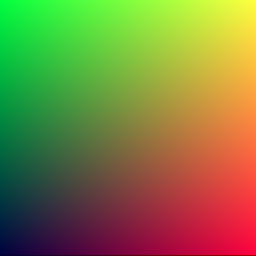

In [5]:
def color_to_int(color):
    ir, ig, ib = [int(255.999 * c) for c in color]
    return ir, ig, ib

image_width = 256
image_height = 256

with open("images/image.ppm", "w") as image_file:
    image_file.write(f"P3\n{image_width} {image_height}\n255\n")
    for j in range(image_height - 1, 0, -1):
        for i in range(image_width):
            pixel_color = Color(i / (image_width - 1), 
                                j / (image_height - 1),
                                0.25)

            ir, ig, ib = color_to_int(pixel_color)

            image_file.write(f"{ir} {ig} {ib}\n")

image = ppm_to_image("images/image.ppm")
display(image)

###### _Figure 2. We read back in and display our image to ensure our output is as intended._

## 2. Rays

The Ray class consists of an origin $\mathbf{A}$ and a direction $\mathbf{b}$.
$\mathbf{P}$ is a 3D position along a line. $\mathbf{P}(t) = \mathbf{A} + t\mathbf{b}$
is a point $t$ distance from $\mathbf{A}$ on the line. $+t$ is in front of
$\mathbf{A}$, $-t$ is behind it. The $+t$ portion of the line is referred to as a
'half-line' or 'ray'.

In [6]:
class Ray(object):
    def __init__(self, origin, direction):
        self.origin = origin
        self.direction = direction
    
    def at(self, scalar):
        return self.origin + scalar * self.direction

### Sending Rays into the Scene
1. calculate the ray from camera -> pixel
2. determine which objects the ray intersects
3. compute a color for the intersection point

In [7]:
def ray_color(ray):
    unit_direction = unit(ray.direction)
    t = 0.5 * (unit_direction.y + 1.0)
    return (1 - t) * Color(1.0, 1.0, 1.0) + t*Color(0.5, 0.7, 1.0)

In [8]:
# Image
aspect_ratio = 16 / 9
image_width = 400
image_height = int(image_width / aspect_ratio)

# Camera
viewport_height = 2.0
viewport_width = aspect_ratio * viewport_height
focal_length = 1.0

origin = Point3(0, 0, 0)
horizontal = Vec3(viewport_width, 0, 0)
vertical = Vec3(0, viewport_height, 0)

lower_left_corner = origin - horizontal/2 - vertical/2 - Vec3(0, 0, focal_length)

filename = "images/blue_to_white.ppm"

# Render
def render_scene_to_ppm(image_width, image_height, origin, lower_left_corner,
                        horizontal, vertical, ray_color, filename):

    with open(filename, "w") as image_file:
       image_file.write(f"P3\n{image_width} {image_height}\n255\n")
       for j in range(image_height - 1, 0, -1):
           for i in range(image_width):
               u = i / (image_width - 1)
               v = j / (image_height - 1)
               r = Ray(origin, lower_left_corner + u * horizontal + v * vertical - origin)
               pixel_color = ray_color(r)
               ir, ig, ib = color_to_int(pixel_color)

               image_file.write(f"{ir} {ig} {ib}\n")

render_scene_to_ppm(image_width, image_height, origin, lower_left_corner,
                    horizontal, vertical, ray_color, filename)

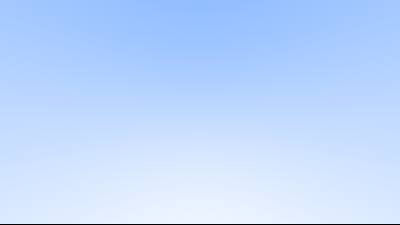

In [9]:
image = ppm_to_image(filename)
display(image)

###### _Figure 3. We color pixels by the y component of our ray to realize a gradient._

## 3. Adding Objects
### Spheres
Recall the equation for a sphere, centered at the origin, with radius $r$ is
$x^2 + y^2 + z^2 = r^2$. If a point $(x, y, z)$ is _on_ the sphere it will satisfy
this equation. If a point $(x, y, z)$ is _inside_ the sphere then
$x^2 + y^2 +z^2 < r^2$. If a given point is _outside_ the sphere then
$x^2 + y^2 +z^2 > r^2$.

If the sphere center is at $\mathbf{C} = (C_x, C_y, C_z)$ the equation will be
$(x-C_x)^2 + (y-C_y)^2 + (z-C_z)^2 = r^2$. Equivalently, in vector notation
$$(\mathbf{P-C}) \cdot (\mathbf{P-C}) = (x-C_x)^2 + (y-C_y)^2 + (z-C_z)^2 = r^2$$

We want to know if our ray $\mathbf{P}(t) = \mathbf{A} + t\mathbf{b}$ ever hits the
sphere; that is, if there is any $t$ for which $\mathbf{P}(t)$ satisfies the
equation of our sphere
$$(\mathbf{P}(t)-\mathbf{C}) \cdot (\mathbf{P}(t)-\mathbf{C}) = r^2$$

or expanding $\mathbf{P}(t)$,

$$(\mathbf{A} + t\mathbf{b} - \mathbf{C}) \cdot (\mathbf{A} + t\mathbf{b} - \mathbf{C}) = r^2$$

Expanding and setting equal to $0$

$t^2\mathbf{b \cdot b} + 2t\mathbf{b} \cdot (\mathbf{A-C})+(\mathbf{A-C})\cdot (\mathbf{A-C}) - r^2 = 0$

A quadratic! We can then utilize the discriminant $\Delta = b^2 - 4ac$ to easily determine the
number of real solutions ie. _intersections_ for a given ray $\mathbf{P}(t)$.

The simplest approach is to color all intersections uniformly.

In [10]:
def hit_sphere(center, radius, ray):
    co = ray.origin - center
    a = dot(ray.direction, ray.direction)
    b = 2 * dot(ray.direction, co)
    c = dot(co, co) - radius**2
    discriminant = b**2 - 4 * a * c

    return True if discriminant > 0 else False

def ray_color(ray):
    if hit_sphere(Point3(0, 0, -1), 0.5, ray):
        color = Color(0.25, 0, 0.75)  # purple
    else:
        unit_direction = unit(ray.direction)
        t = 0.5 * (unit_direction.y + 1)
        color = (1 - t) * Color(1, 1, 1) + t * Color(0.5, 0.7, 1)

    return color

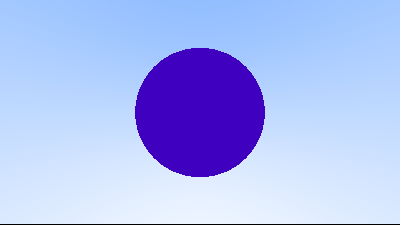

In [11]:
filename = "images/purple_sphere.ppm"
render_scene_to_ppm(image_width, image_height, origin, lower_left_corner,
                    horizontal, vertical, ray_color, filename)

image = ppm_to_image(filename)
display(image)

###### _Figure 4. We color our sphere uniformly._

## 4. Surface Normals
### Shading
Given our intersection solution $t$ we can calculate the surface normal and map the
$x, y, z$ components to $r, g, b$ to shade our sphere.

In [12]:
def hit_sphere(center, radius, ray):
    co = ray.origin - center
    a = dot(ray.direction, ray.direction)
    b = 2 * dot(ray.direction, co)
    c = dot(co, co) - radius**2
    discriminant = b**2 - 4 * a * c

    return False if discriminant < 0 else (-b - math.sqrt(discriminant)) / 2 * a


def ray_color(ray):
    center, radius = Point3(0, 0, -1), 0.5
    t = hit_sphere(center, radius, ray)
    if t:
        # map x, y, z of the surface normal to r, g, b
        normal = Vec3(*unit(ray.at(t) - center))
        color = 0.5 * Color(normal.x + 1, normal.y + 1, normal.z + 1)
    else:
        unit_direction = unit(ray.direction)
        t = 0.5 * (unit_direction.y + 1)
        color = (1 - t) * Color(1, 1, 1) + t * Color(0.5, 0.7, 1)

    return color

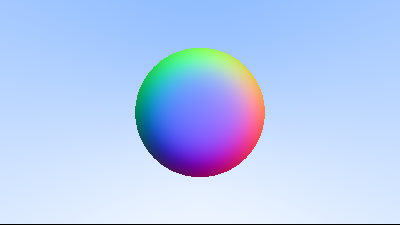

In [13]:
filename = "images/rainbow_sphere.ppm"
render_scene_to_ppm(image_width, image_height, origin, lower_left_corner,
                    horizontal, vertical, ray_color, filename)

image = ppm_to_image(filename)
display(image)

###### _Figure 5. We shade our sphere according to the surface normal at each intersection._